## AIPI 590 - XAI | Assignment #6
### Explainable Techniques II
#### Author: Tal Erez
#### Colab Notebook:
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)]()

### To Run in Colab

Verify you are running on a GPU. On the top right of the screen click the down arrow in between "RAM/Disk" and "Gemini"  -> Change Runtime Type -> T4 GPU -> Save

### Introduction
This notebook demonstrates how to use PDP, Ice Plots and Ale Plots to generate global explanations. The data used for this notebook is the "Pima Indians Diabetes Database" from Kaggle. The dataset is designed to predict whether or not a patient has diabetes. All patients surveyed in this dataset are females at least 21 years old of Pima Indian heritage.

### Install required dependencies and import packages

In [2]:
import os

# Remove Colab default sample_data if it exists
if os.path.exists("./sample_data"):
    !rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "ExplainableTechniques"

# Check if the repo already exists
if not os.path.exists("/content/" + repo_name):
    git_path = 'https://github.com/notthattal/ExplainableTechniquesII.git'
    !git clone "{git_path}"
else:
    print(f"{repo_name} already exists.")

# Change working directory to location of notebook
path_to_notebook = os.path.join("/content/" + repo_name)
%cd "{path_to_notebook}"
%ls

!pip install -r requirements.txt

from alepython import ale_plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
import xgboost

np.random.seed(1)

/Users/talerez/Documents/AIPI_590_XAI/ExplainableTechniquesII/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the Dataset

In [18]:
#Load the dataset 
df = pd.read_csv('./data/diabetes.csv')
  
# Split the df into features and target
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Exploratory Data Analysis

We can observe visually that the highest absolute value of correlation in the correlation matrix is 0.54 which suggests a moderate amount of correlation between pregnancies and age. However the correlation is not strong enough to be considered high correlation.

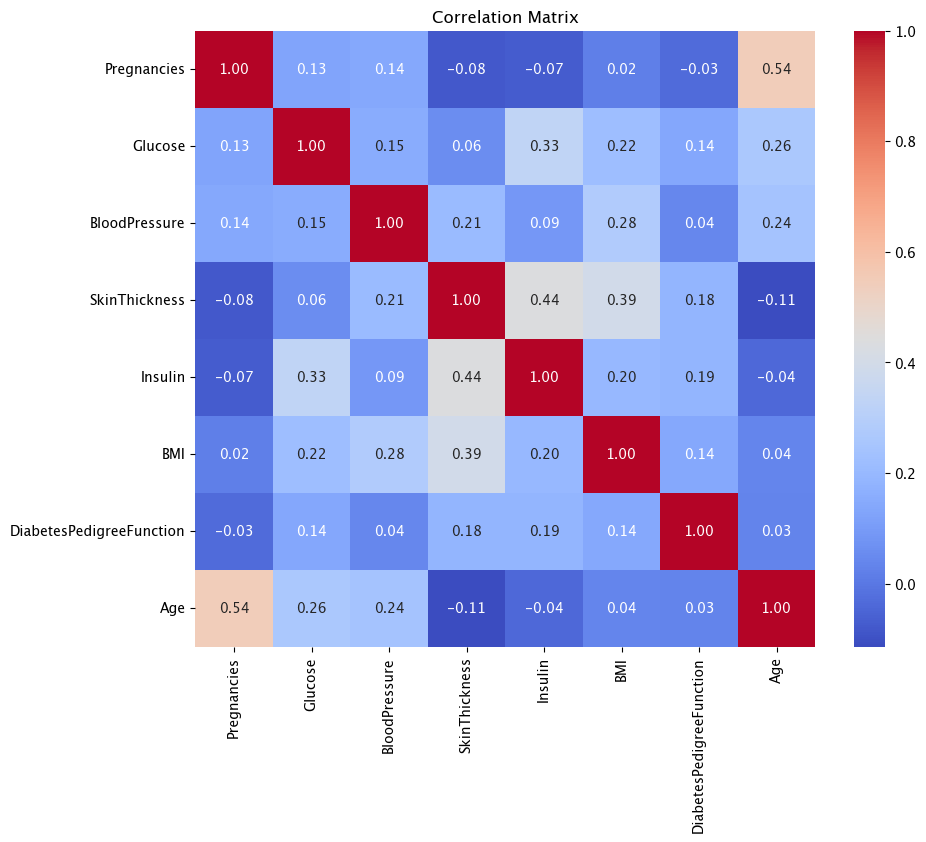

In [4]:
# Get the correlation matrix on the full feature set
correlation_matrix = X.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)

# Show the heatmap
plt.title('Correlation Matrix')
plt.show()

### Create and Fit The Model to the Training Set

In [5]:
# create and fit the XGBoost Classifier model to the training set
model = xgboost.XGBClassifier().fit(X_train, y_train)

### Partial Dependence Plots

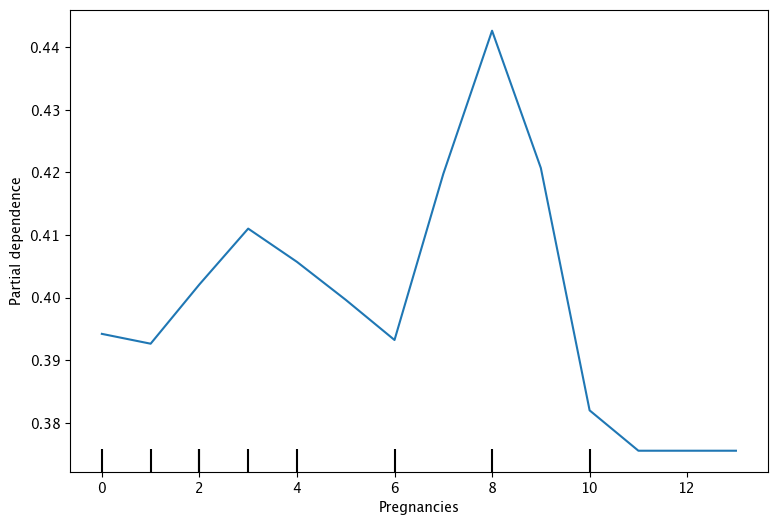

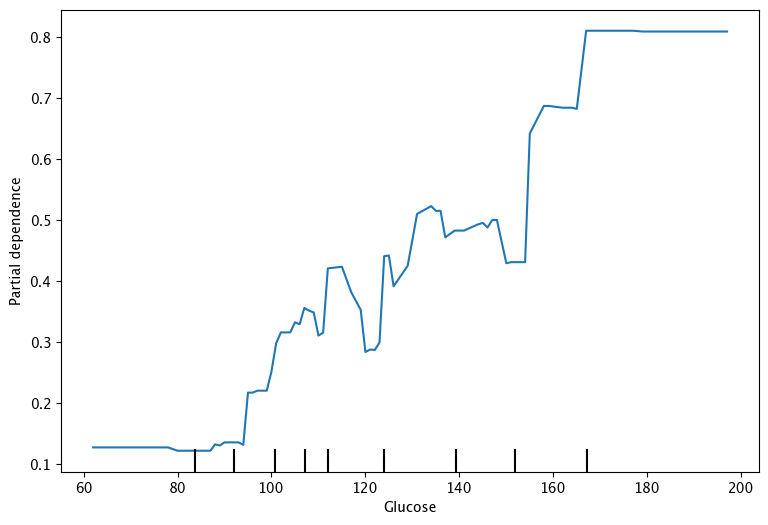

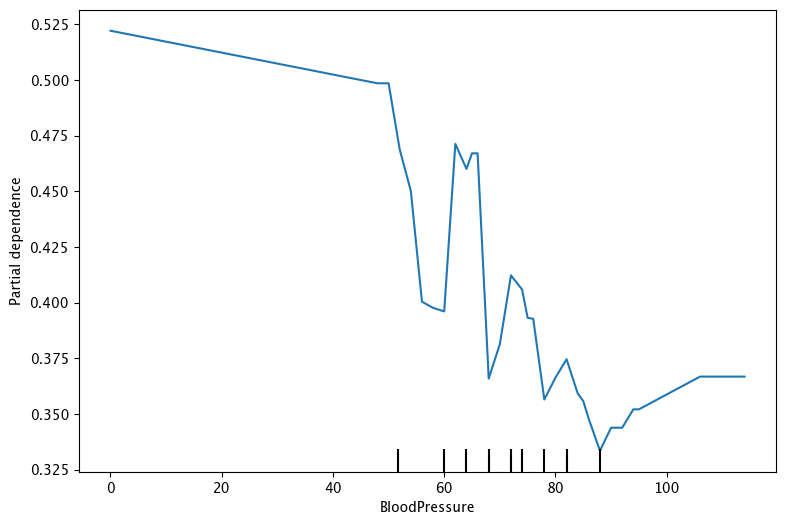

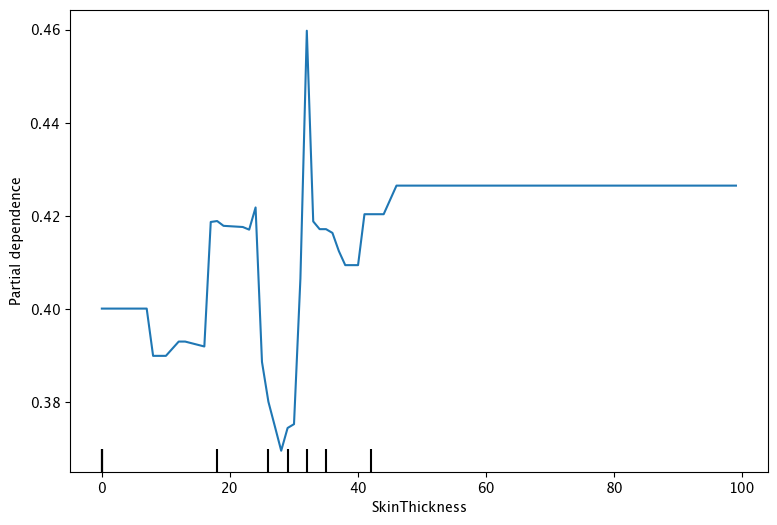

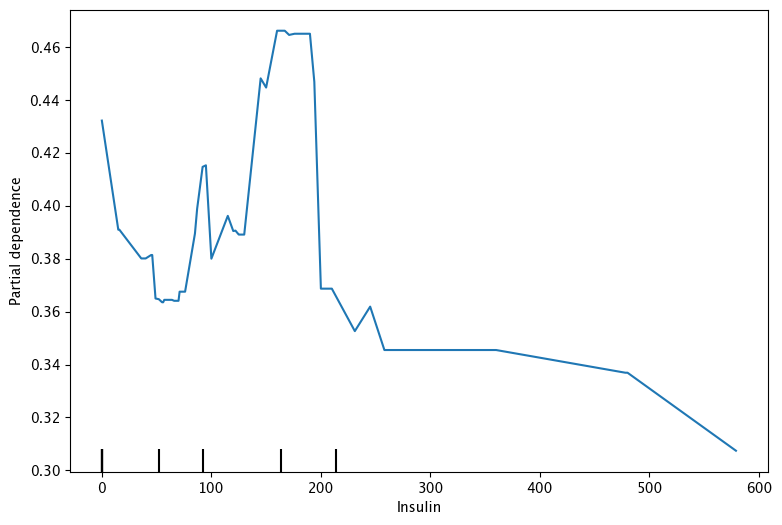

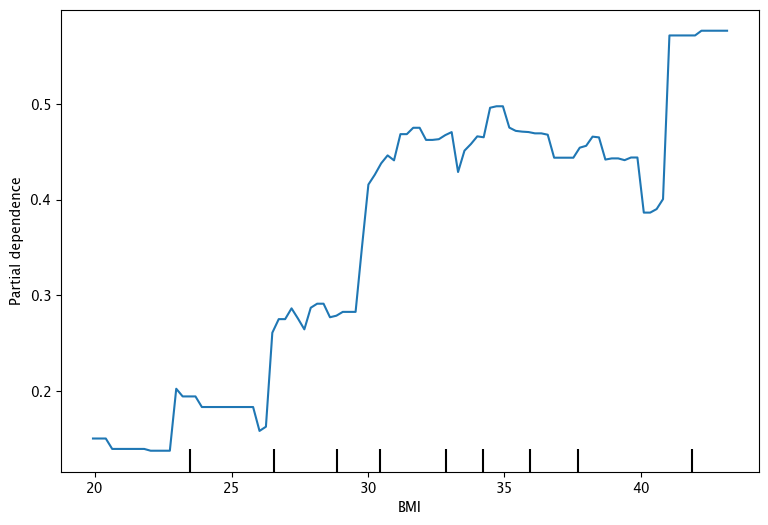

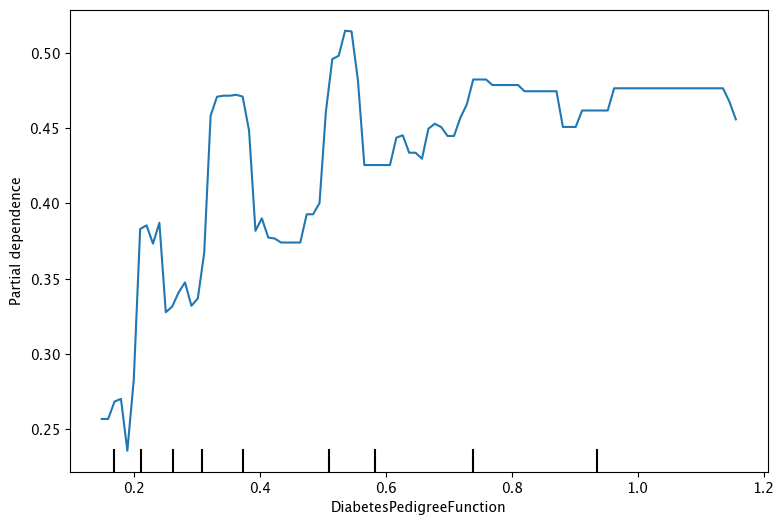

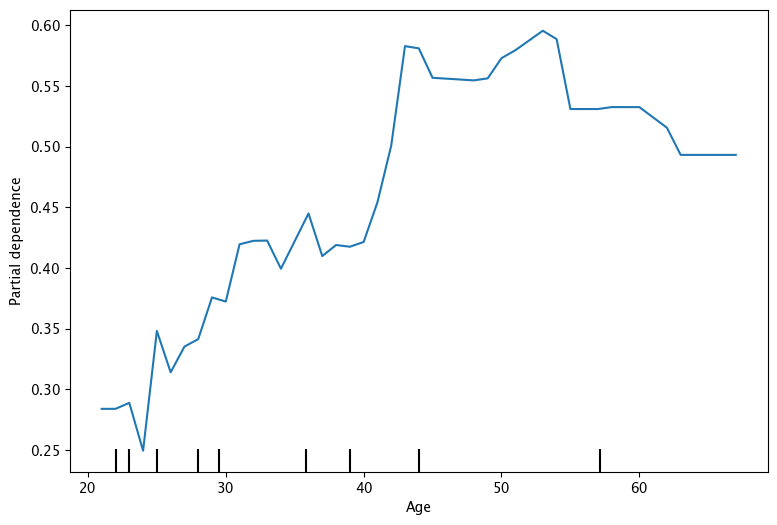

In [13]:
# get the PDP plot for each feature on the test set 
for col in X.columns:
    PartialDependenceDisplay.from_estimator(model, X_test, [col], kind='average', target=1)

#### Discussion:
- Pregnancies: For the number of pregnancies, we can see that the plot is non-linear and that higher predictions are most common for Women with 8 pregnancies and 2nd highest for women with 3 pregnancies. After 8 pregnancies, the prediction begins to dramatically decline.
- Glucose: We can see that there is a general positive trend where as glucose rises the prediction tends to also rise. However, around the 170 mark, the predictions begin to plateau at a maximum of 0.8 suggesting little effect on prediction for values higher than that level.
- Blood Pressure: In contrast to glucose, blood pressure shows a downward linear trend up until around the 90 mark for which it begins to increase. Low blood pressure is typically attributed to a reading below 90, so this could suggest that people with low blood pressure are likelier to have a positive prediction. The range for stage 1 hypertension is generally a reading over 130 for which this data doesn't seem to cover. Perhaps the increase after 90 would show a higher reading as well for people with high blood pressure.
- Skin Thickness: Skin thickness doesn't seem to show any specific trend for the lower levels. It dips at around 30, spikes at around 35 and plateaus at around the 50 mark. That is, for any values over 50, there is no difference in prediction outcome.
- Insulin: Lower insulin levels tend to have a lower prediction than values between 150 and 200 (where it spikes), and after 200 the prediction dramatically drops and somewhat plateaus. However, there is a generally negative trend on prediction as insulin increases past 350.
- BMI: The effect of BMI on predictions is somewhat sporadic, however we can see that generally a higher BMI would lead to a higher prediction.
- Diabetes Pedigree Function: The diabetes pedigree function seems to show a somewhat logarithmic pattern suggesting that as it increases for the lower values the effect it has on prediction is much more dramatic compared to a change from an already high value to an even higher value
- Age: For Age, There is a positive trend where prediction is higher as age increases, however after around age 55 there is a slight dip in the prediction value which continues to decrease as age increases.

### ICE Plots

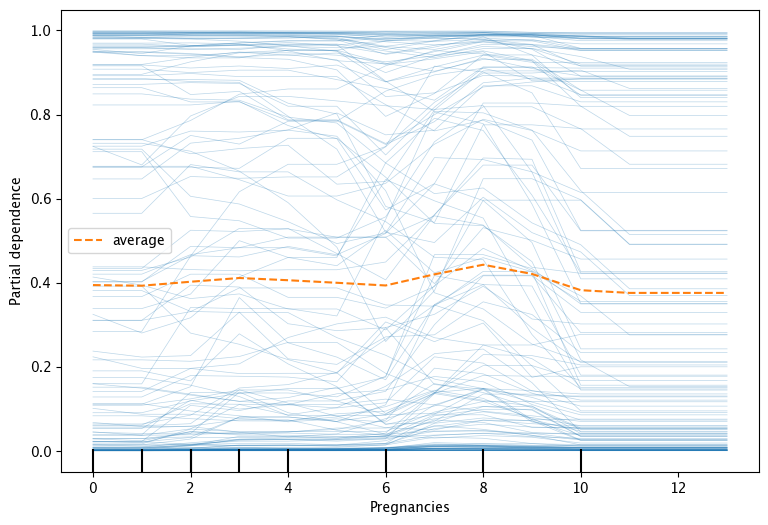

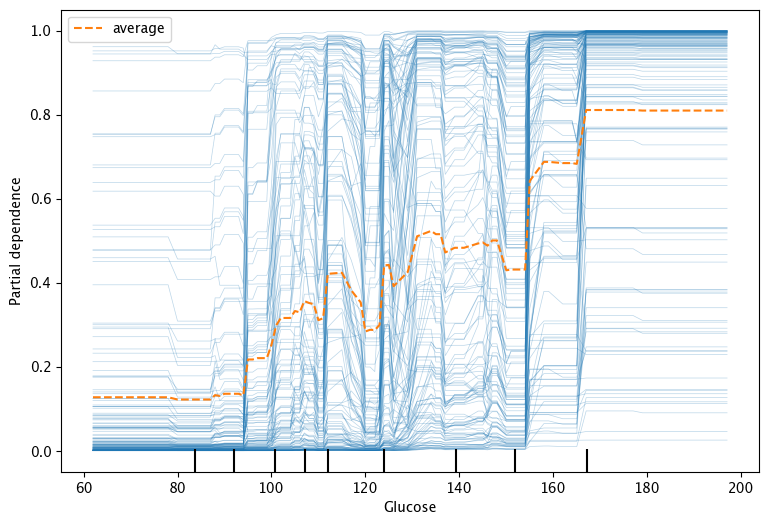

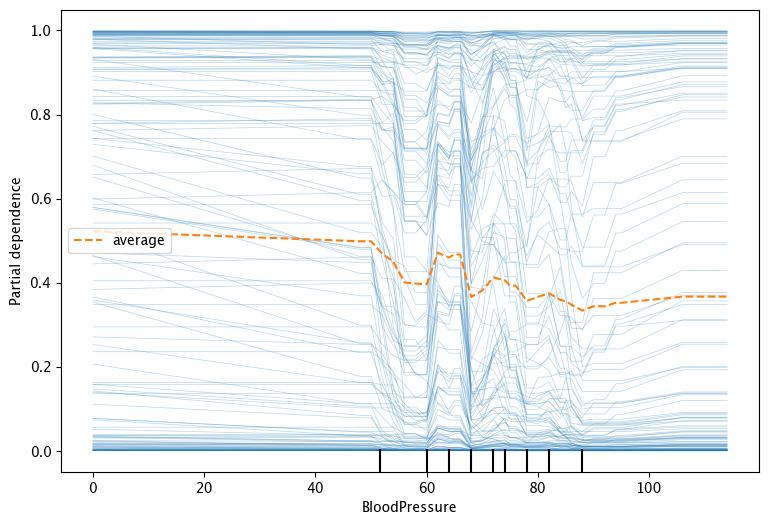

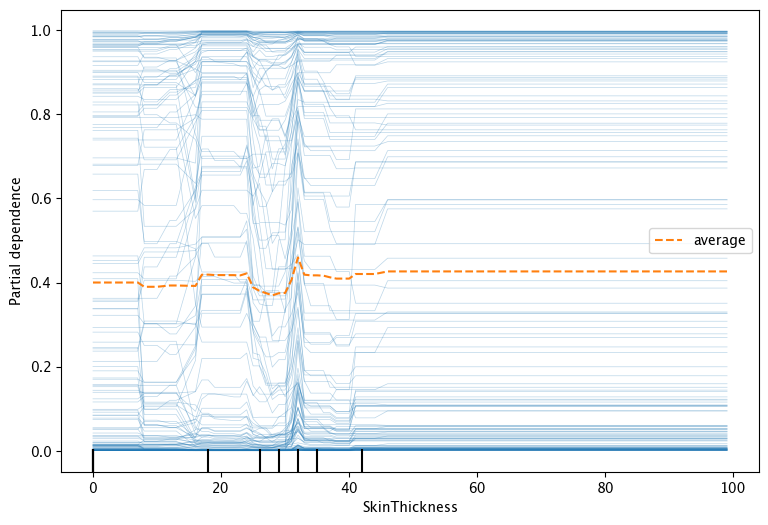

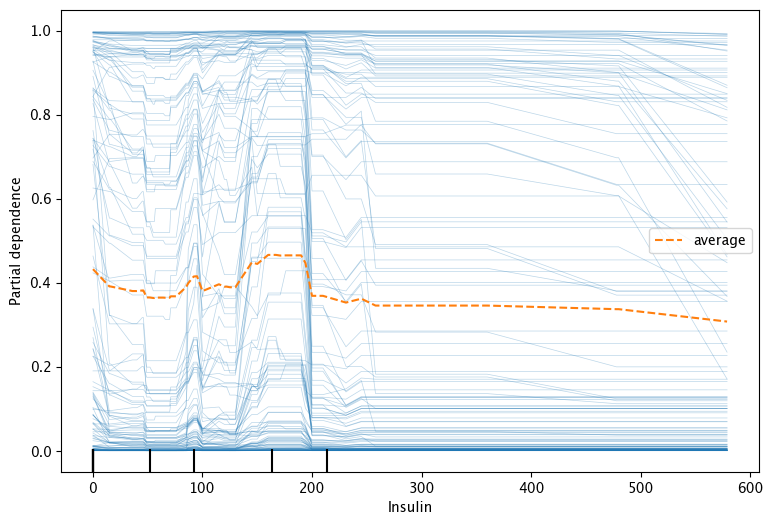

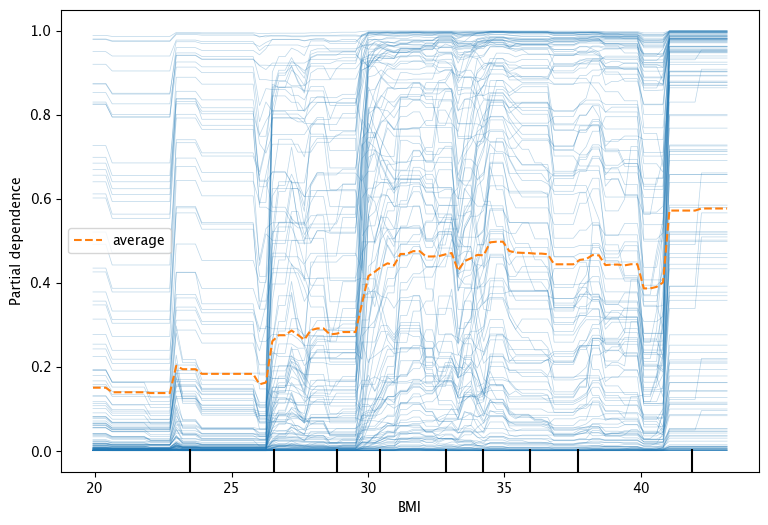

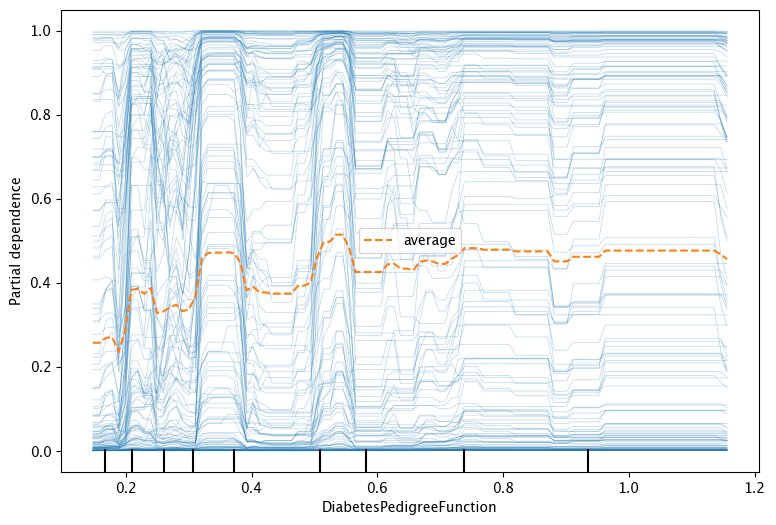

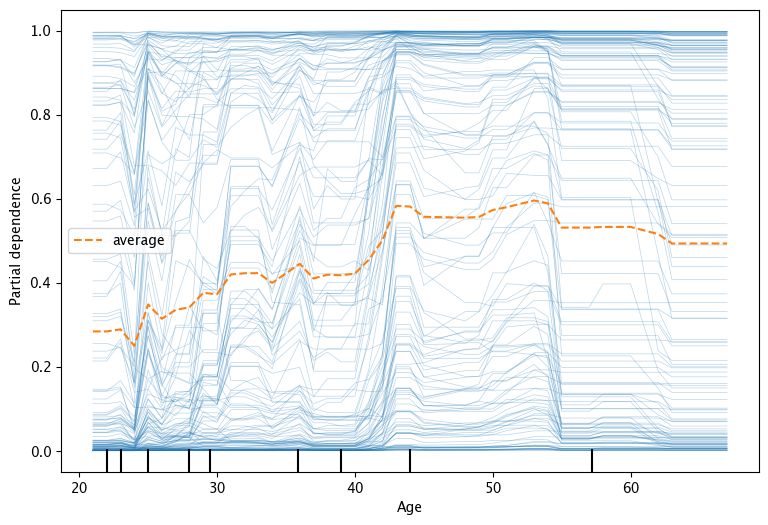

In [20]:
# Plot the ICE Plots for each feature overlaying the PDP plot for easier readability
for col in X.columns:
    PartialDependenceDisplay.from_estimator(model, X_test, [col], kind='both', target=1)

#### Discussion:
- Pregnancies: We can see that for many of the instances there is a spike in predictions at 8 pregnancies and a smaller spike for 3 pregnancies as suggested by the average PDP plot
- Glucose: For glucose we also generally see an increase in prediction value as glucose increases
- Blood Pressure: We do notice a downward trend as blood pressure increases. While after 90 there also shows an upward trend as discussed above, the increase seems much less dramatic when viewing against all ICE plots, perhaps suggesting low blood pressure is a more important indicator than higher blood pressure.
- Skin Thickness: When looking at skin thickness in the context of the ICE plot, the average seems relatively flat suggesting that skin thickness may not have much of an effect on predictions.
- Insulin: Similar to skin thickness, apart from the 150-200 spike as mentioned above, the average also seems somewhat flat suggesting that it may not be the best indicator if it's outside the spiked range.
- BMI: BMI however still shows a positive trend and a higher BMI seems to be a stronger indicator that predictions will be higher
- Diabetes Pedigree Function: This feature also shows a positive trend up until it reaches its higher values where it begins to plateau slightly
- Age: We see similar trends for the age value where it has a positive trend until around age 55 where it begins to dip back down, but only slightly.

### ALE Plots

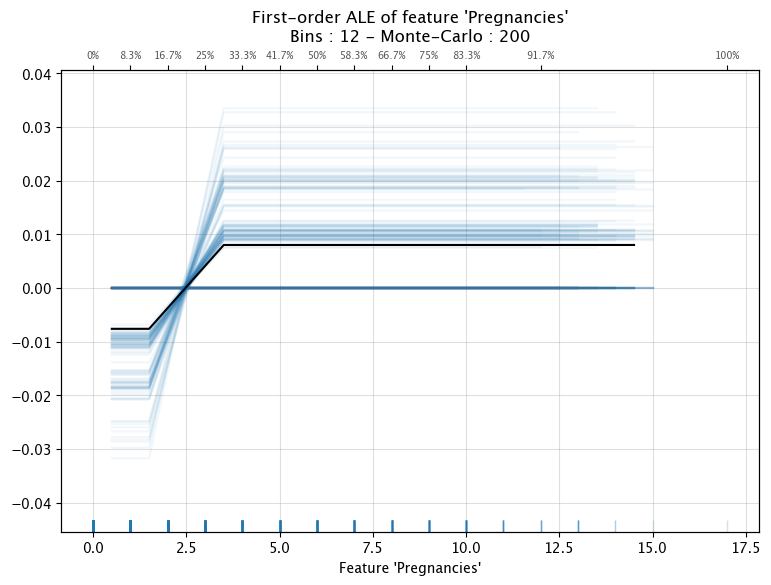

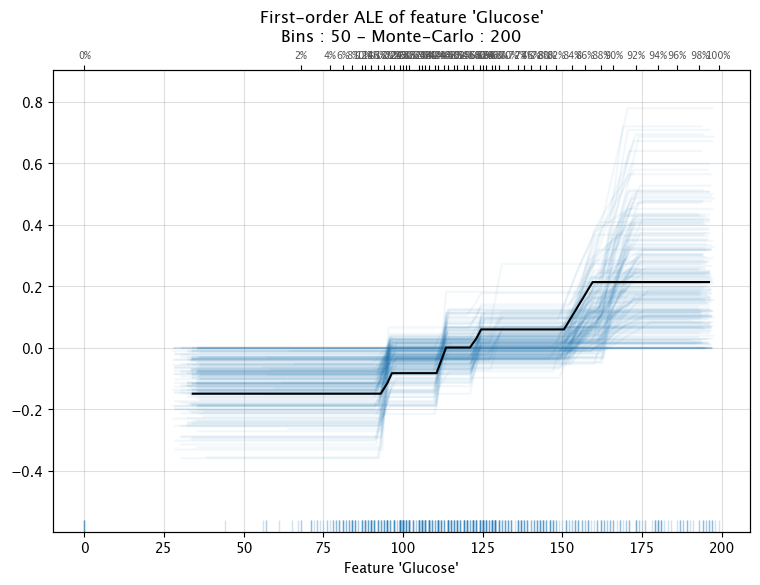

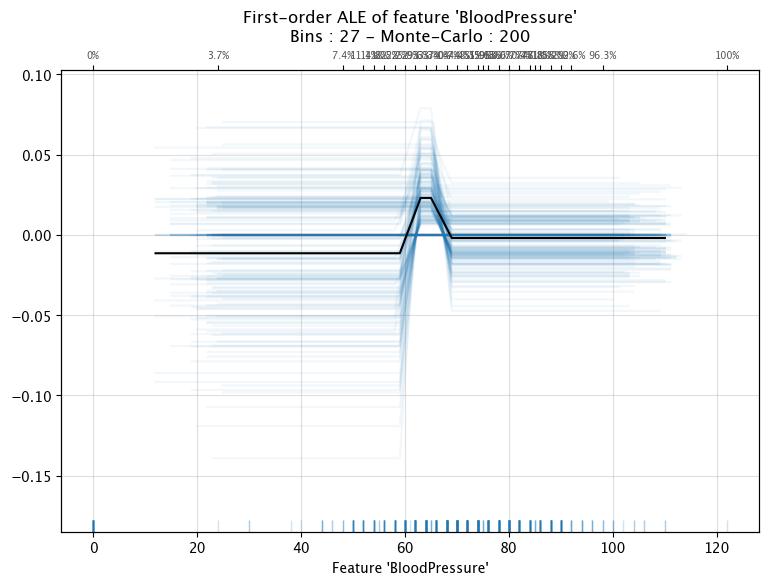

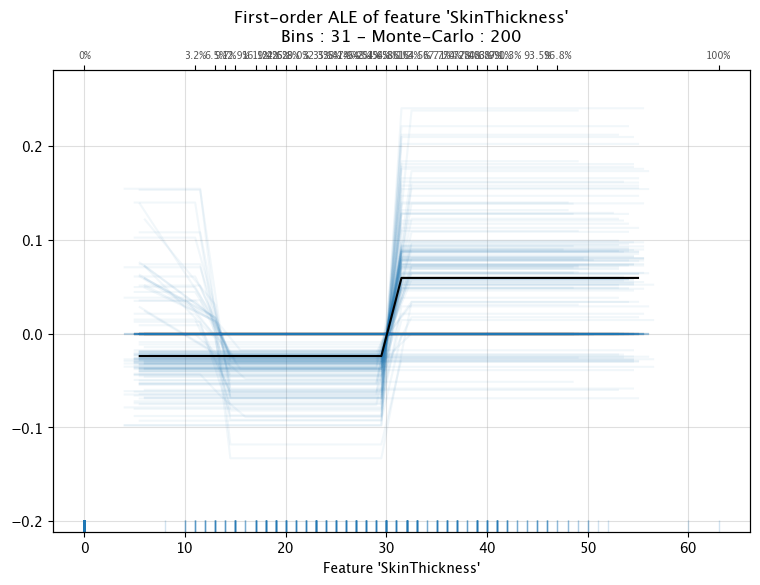

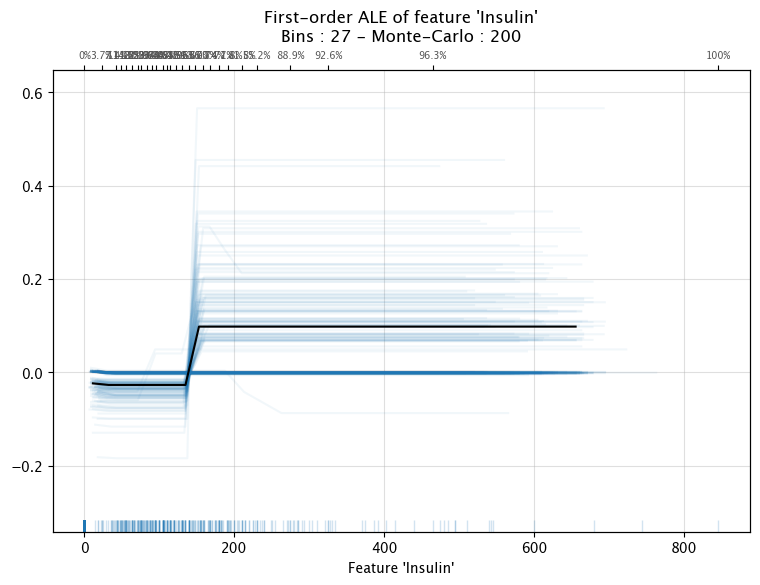

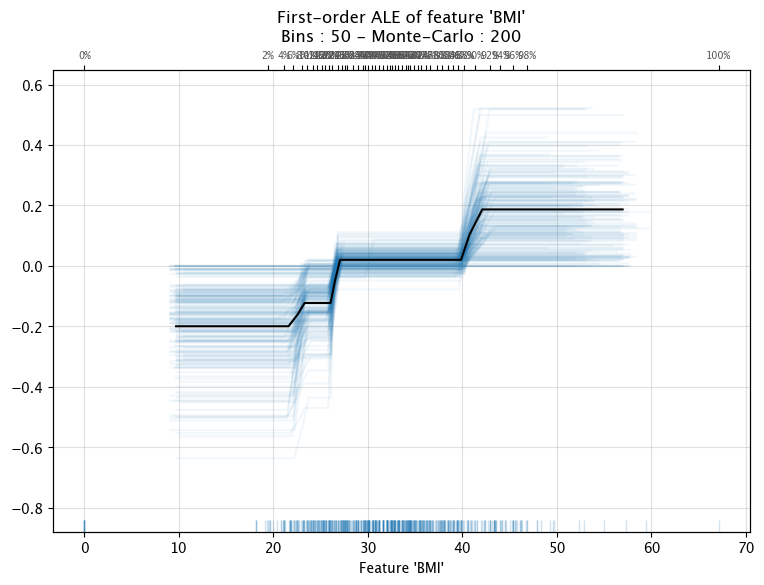

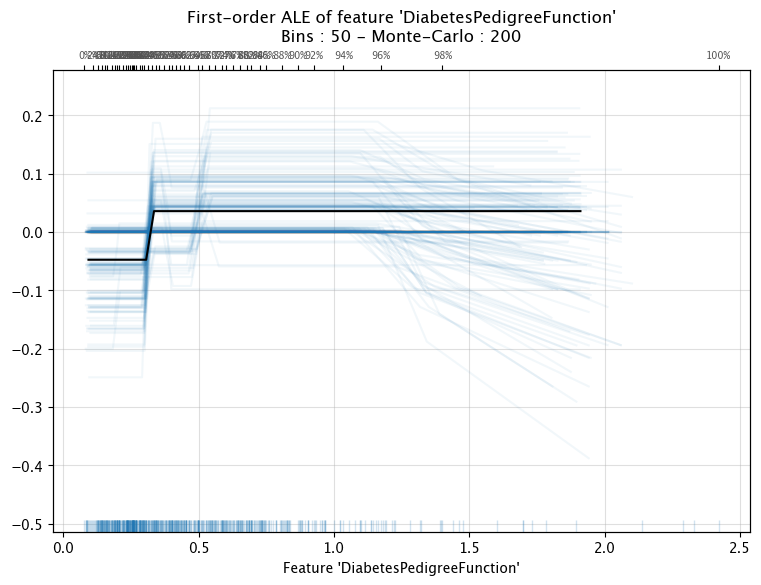

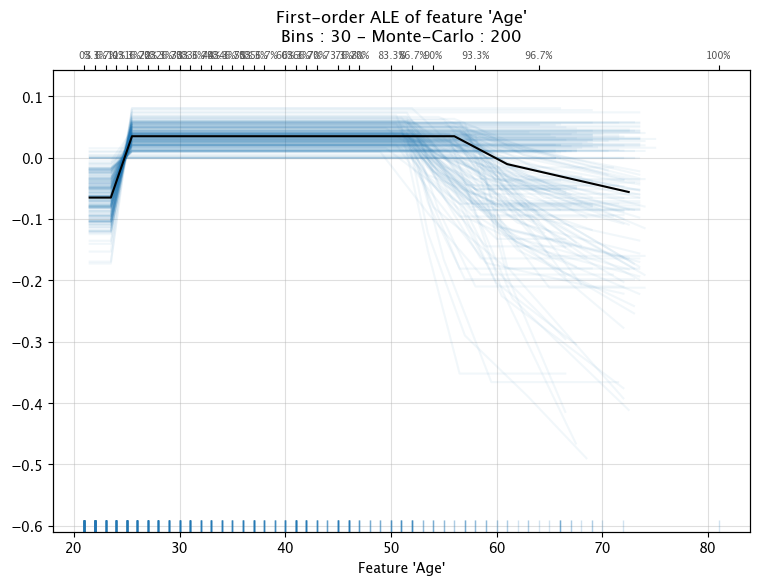

In [22]:
#set the plot size a bit larger for easier visibility
plt.rc("figure", figsize=(9, 6))

# plot the ALE plot for each feature of the training set
for col in X_train.columns:
    ale_plot(model, X_train, col, bins=50, monte_carlo=True, monte_carlo_rep=200, monte_carlo_ratio=0.8)

#### Discussion: ALE Plot Interpretation vs PDP plots
- Pregnancies: The ALE Plot for pregnancies is almost completely flat apart from an increase between 2-3 pregnancies suggesting little to no effect on predictions which differs from the PDP plot which suggested a spike in predictions at 3 and 8 pregnancies
- Glucose: The ALE plot for glucose further solidifies our findings from the PDP plots by showing a positive trend up until the higher glucose levels where both plots tend to flatten out.
- Blood Pressure: As opposed to the PDP plot the ALE plot tends to show a flat line which turns to a positive trend between 57-65 then it decreases until around 70-75 where it plateaus. This suggests a lower range for which blood pressure makes an impact on prediction compared to the PDP plot.
- Skin Thickness: Similar to blood pressure, skin thickness compared to the PDP plot shows a smaller range of impact on prediction. Suggesting little to no effect for the lower end and higher end of the skin thickness ranges.
- Insulin: Insulin for the ALE plot also shows lower predictions for the lower ranges, then an increase up until a specific point and then it flattens out suggesting little to no effect on predictions after that point as opposed to a downward trend for the higher ranges like in the PDP plot.
- BMI: There are more plateaus in the ALE plot compared to the PDP plot, however we do continue to see that the higher the BMI the higher the prediction. 
- Diabetes Pedigree Function: This feature as an ALE plot doesn't show a logarithmic pattern. Rather, it shows a spike in the lower values and than a flat line. A relatively stark difference compared to the PDP plot interpretation.
- Age: The ALE plot doesn't tend to show a positive trend like the PDP plot did. It shows a spike between around 22-25 and then little to no effect on prediction up until around 47. However, it then also shows a downward trend as age increases past 47 similar to the PDP plot.

### References

- UCI Machine Learning, Kaggle Team "Pima Indians Diabetes Database" Kaggle, 2016, https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
- Bent, Brinnae, PhD "XAI Code Demo: Global Explanations" Github, 2024, https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb
- Bent, Brinnae, PhD "XAI Code Demo: Local Explanations" Github, 2024, https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/local_explanations.ipynb